# 데이터테이블 수정 후 작업
- 1. year, month, date가 int값으로 되어있어 회귀분석에 영향을 줌
    + 이 셋을 categorical화 시킴
    + one-hot을 진행해 연도, 월, 날의 불필요한 영향 제거

- 2. XGBRegressor가 가장 성적이 좋으며 중식 : 90/86 // 석식 : 91/63
- 3. forecast 데이터테이블 자동 업데이트, 전처리 되도록 함수 생성

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='/Users/hoon/Library/Fonts/NanumSquareRegular.ttf').get_name()
plt.rc("font", family=font_name)
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import requests as req
import time
import re
import pickle


from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold # 데이터 나누기, 점검 및 훈련

from sklearn.metrics import explained_variance_score, accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score # 평가지표
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler # Feature Scaling


from sklearn.neighbors import KNeighborsRegressor

from sklearn.datasets import load_iris, load_boston, load_breast_cancer, make_moons, load_digits, load_diabetes, load_wine, make_blobs # 데이터
import mglearn # 그래프

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVC, LinearSVR

# conda install -c conda -py
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

from sklearn.pipeline import make_pipeline
import multiprocessing
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPRegressor

# pip install lightgbm
# conda install -c conda-forge lightgbm
from lightgbm import LGBMRegressor
from lightgbm import plot_importance, plot_tree, plot_metric

import graphviz

import statsmodels.api as sm

# SVC는 분류, SVR은 회귀
# 분류알고리즘에선 끝판왕으로 불림
from sklearn.svm import SVR, SVC

## 1. 데이터 불러오기

In [4]:
lunch = pd.read_csv("data/lunch_df_encoding.csv")
dinner = pd.read_csv("data/dinner_df_encoding.csv")

In [5]:
lunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               1205 non-null   object 
 1   year                   1205 non-null   int64  
 2   month                  1205 non-null   int64  
 3   date                   1205 non-null   int64  
 4   worker_number          1205 non-null   int64  
 5   real_number            1205 non-null   int64  
 6   vacation_number        1205 non-null   int64  
 7   biztrip_number         1205 non-null   int64  
 8   overtime_number        1205 non-null   int64  
 9   telecom_number         1205 non-null   int64  
 10  temperature            1204 non-null   float64
 11  rain                   1205 non-null   float64
 12  wind                   1204 non-null   float64
 13  humidity               1205 non-null   float64
 14  discomfort_index       1204 non-null   float64
 15  perc

In [6]:
dinner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               1205 non-null   object 
 1   year                   1205 non-null   int64  
 2   month                  1205 non-null   int64  
 3   date                   1205 non-null   int64  
 4   worker_number          1205 non-null   int64  
 5   real_number            1205 non-null   int64  
 6   vacation_number        1205 non-null   int64  
 7   biztrip_number         1205 non-null   int64  
 8   overtime_number        1205 non-null   int64  
 9   telecom_number         1205 non-null   int64  
 10  temperature            1204 non-null   float64
 11  rain                   1205 non-null   float64
 12  wind                   1204 non-null   float64
 13  humidity               1205 non-null   float64
 14  discomfort_index       1204 non-null   float64
 15  perc

In [7]:
lunch = lunch.dropna()
dinner = dinner.dropna()

In [8]:
def split_lunch(data):
    data_train = data.drop(["lunch_number", "datetime"], axis = "columns")
    data_target = data.loc[:, 'lunch_number']
    times = ['year', 'month', 'date']
    for col in times:
        data_train[col] = data_train[col].astype('category')
    data_train = pd.get_dummies(data_train)
    X_train, X_test, y_train, y_test = train_test_split(data_train, data_target)

    return X_train, X_test, y_train, y_test

def split_dinner(data):
    data_train = data.drop(["dinner_number", "datetime"], axis = "columns")
    data_target = data.loc[:, 'dinner_number']
    times = ['year', 'month', 'date']
    for col in times:
        data_train[col] = data_train[col].astype('category')
    data_train = pd.get_dummies(data_train)
    X_train, X_test, y_train, y_test = train_test_split(data_train, data_target)

    return X_train, X_test, y_train, y_test

In [9]:
lunch_X_train, lunch_X_test, lunch_y_train, lunch_y_test = split_lunch(lunch)
dinner_X_train, dinner_X_test, dinner_y_train, dinner_y_test = split_dinner(dinner)

In [10]:
lunch_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 288 to 312
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   worker_number          902 non-null    int64  
 1   real_number            902 non-null    int64  
 2   vacation_number        902 non-null    int64  
 3   biztrip_number         902 non-null    int64  
 4   overtime_number        902 non-null    int64  
 5   telecom_number         902 non-null    int64  
 6   temperature            902 non-null    float64
 7   rain                   902 non-null    float64
 8   wind                   902 non-null    float64
 9   humidity               902 non-null    float64
 10  discomfort_index       902 non-null    float64
 11  perceived_temperature  902 non-null    float64
 12  lunch_rice             902 non-null    int64  
 13  season_fall            902 non-null    int64  
 14  season_spring          902 non-null    int64  
 15  seas

In [11]:
dinner_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 394 to 943
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   worker_number          902 non-null    int64  
 1   real_number            902 non-null    int64  
 2   vacation_number        902 non-null    int64  
 3   biztrip_number         902 non-null    int64  
 4   overtime_number        902 non-null    int64  
 5   telecom_number         902 non-null    int64  
 6   temperature            902 non-null    float64
 7   rain                   902 non-null    float64
 8   wind                   902 non-null    float64
 9   humidity               902 non-null    float64
 10  discomfort_index       902 non-null    float64
 11  perceived_temperature  902 non-null    float64
 12  dinner_rice            902 non-null    int64  
 13  season_fall            902 non-null    int64  
 14  season_spring          902 non-null    int64  
 15  seas

In [12]:
lunch_X_test.head()

,worker_number,real_number,vacation_number,biztrip_number,overtime_number,telecom_number,temperature,rain,wind,humidity,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
701,2846,2516,87,243,525,0,1.5,0.0,0.4,68.5,...,0,0,0,0,0,0,0,0,0,0
211,2705,2225,196,284,152,0,6.9,0.0,1.6,49.9,...,0,0,0,0,0,0,0,0,0,0
273,2627,2191,145,291,63,0,5.6,0.0,1.0,42.0,...,0,0,0,0,0,0,0,0,0,0
433,2644,2301,75,268,462,0,13.0,0.0,0.6,74.9,...,0,0,0,0,0,0,0,0,0,0
537,2714,2375,118,221,523,0,12.9,0.0,1.4,53.8,...,0,0,0,0,0,0,0,0,0,0


In [13]:
dinner_X_train.head()

,worker_number,real_number,vacation_number,biztrip_number,overtime_number,telecom_number,temperature,rain,wind,humidity,...,date_22,date_23,date_24,date_25,date_26,date_27,date_28,date_29,date_30,date_31
394,2642,2303,74,265,390,0,21.5,0.7,0.9,76.3,...,0,0,0,0,0,0,0,0,0,0
125,2644,1977,467,200,262,0,27.1,0.0,1.2,73.6,...,0,0,0,0,0,0,0,0,0,0
1112,3132,2307,119,195,531,511,25.8,50.5,3.9,66.6,...,0,0,0,0,0,0,0,0,0,0
556,2721,2357,133,231,590,0,14.9,0.0,2.0,65.1,...,0,0,0,0,0,0,0,0,0,0
414,2645,2335,60,250,0,0,21.1,0.0,1.0,72.8,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# lunch_X_train.to_csv("data/split/lunch_X_train.csv", encoding='utf-8', index=False)
# lunch_X_test.to_csv("data/split/lunch_X_test.csv", encoding='utf-8', index=False)
# lunch_y_train.to_csv("data/split/lunch_y_train.csv", encoding='utf-8', index=False)
# lunch_y_test.to_csv("data/split/lunch_y_test.csv", encoding='utf-8', index=False)
# dinner_X_train.to_csv("data/split/dinner_X_train.csv", encoding='utf-8', index=False)
# dinner_X_test.to_csv("data/split/dinner_X_test.csv", encoding='utf-8', index=False)
# dinner_y_train.to_csv("data/split/dinner_y_train.csv", encoding='utf-8', index=False)
# dinner_y_test.to_csv("data/split/dinner_y_test.csv", encoding='utf-8', index=False)

## 2. LinearRegression

In [16]:
lunch_X_train=pd.read_csv("data/split/lunch_X_train.csv")
lunch_X_test=pd.read_csv("data/split/lunch_X_test.csv")
lunch_y_train=pd.read_csv("data/split/lunch_y_train.csv")
lunch_y_test=pd.read_csv("data/split/lunch_y_test.csv")
dinner_X_train=pd.read_csv("data/split/dinner_X_train.csv")
dinner_X_test=pd.read_csv("data/split/dinner_X_test.csv")
dinner_y_train=pd.read_csv("data/split/dinner_y_train.csv")
dinner_y_test=pd.read_csv("data/split/dinner_y_test.csv")

### 점심

In [17]:
lr = LinearRegression()
lr.fit(lunch_X_train, lunch_y_train)

print("기울기 : {0}, 절편 : {1}".format(lr.coef_, lr.intercept_))
print("훈련 설명력 : {}".format(lr.score(lunch_X_train, lunch_y_train)))
print("테스트 설명력 : {}".format(lr.score(lunch_X_test, lunch_y_test)))

기울기 : [[ 1.13059138e+13 -1.13059138e+13 -1.13059138e+13 -1.13059138e+13
   2.38281250e-01 -1.13059138e+13  3.29296875e+01  1.26745605e+00
  -1.83566589e+01  7.85385132e-01 -5.46847534e+00 -2.63050537e+01
   3.05175781e-05  5.03477859e+00 -1.01627350e+01  1.67403584e+01
  -1.16124783e+01 -7.36395359e+01  1.44866682e+02 -7.87282581e+01
  -4.54209833e+01  5.29222560e+01  1.73616467e+01 -1.73616519e+01
  -2.68873926e+01  2.68873892e+01  4.22482506e+01  3.58335898e+01
   4.27073306e+01  1.26705122e+01 -7.47107023e+01 -5.87490189e+01
  -1.73876482e+01  5.79107372e+01  8.42953414e+00 -3.91913190e+01
   2.05990554e+01 -2.80794165e+01 -1.17333224e+01  5.65530664e+01
  -7.95450979e+00  3.51998407e+01 -2.22105065e+01 -5.21355751e+01
  -1.19980212e+01  3.05332513e+01  1.42331254e+01  5.65376680e+00
  -1.06826908e+01  1.08066349e+01  2.47373862e+01  2.77672729e+01
   1.16738781e+00  8.78349966e+00  1.81383563e+01 -7.70575871e+00
  -1.95851484e+01  8.57564775e+00 -1.24276220e+01  2.90927037e+01
   6

### 저녁

In [18]:
lr = LinearRegression()
lr.fit(dinner_X_train, dinner_y_train)

print("기울기 : {0}, 절편 : {1}".format(lr.coef_, lr.intercept_))
print("훈련 설명력 : {}".format(lr.score(dinner_X_train, dinner_y_train)))
print("테스트 설명력 : {}".format(lr.score(dinner_X_test, dinner_y_test)))

기울기 : [[ 3.19558948e+12 -3.19558948e+12 -3.19558948e+12 -3.19558948e+12
   3.07128906e-01 -3.19558948e+12  1.27355957e+01  3.65737915e-01
  -1.00421638e+01 -2.62134552e-01 -4.05921936e-01 -1.03546028e+01
  -5.72204590e-06 -4.73717308e+00  1.31138725e+01 -7.49961376e-01
  -7.62670374e+00  6.63777947e+01 -1.47301283e+01 -5.02882051e+00
  -2.03245878e+01 -2.62942872e+01  7.51502436e+00 -7.51502839e+00
   7.97423193e+00 -7.97423261e+00  8.67263487e+01  2.89136296e+01
   5.47083350e+01  1.40705726e+01 -5.70251600e+01 -1.27393644e+02
  -7.94776911e+00  5.56666793e+01  2.84713453e+01 -1.34939497e+01
  -1.86353449e+00 -1.71853476e+01 -1.52806927e+01  3.17160776e+01
  -1.56021438e+01  2.94010458e+01 -1.85361010e+01 -5.53456323e+01
  -1.84342786e+01  2.83781934e+01  9.57981948e+00  3.13984313e+01
   2.20433202e+01  3.19662682e+01  2.00256427e+01  3.03066862e+01
   1.25338656e+01  1.36909631e+01  2.42842944e+01  1.12450656e+00
   1.12310684e+01  5.58197916e+00  1.36497432e+01  2.37115349e+01
  -6

## 3. SVR

### 점심

In [19]:
pipe = Pipeline([('standardscaler', StandardScaler()), ("model", SVR(kernel='linear'))])
params = [{"model__gamma":['scale', 'auto'], 'model__C':[1.0, 0.1, 0.01]}]

gs = GridSearchCV(estimator=pipe, param_grid=params, n_jobs=multiprocessing.cpu_count(), verbose=True, cv=5)

gs.fit(lunch_X_train, lunch_y_train)

print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d arr

{'model__C': 1.0, 'model__gamma': 'scale'}
0.7627546754441044


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d arr

In [20]:
model = SVR(kernel='linear', C=1.0, gamma='scale')
model.fit(lunch_X_train, lunch_y_train)

print("훈련 결과 : {}".format(model.score(lunch_X_train, lunch_y_train)))
print("점검 결과 : {}".format(model.score(lunch_X_test, lunch_y_test)))

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 결과 : 0.7613506932960563
점검 결과 : 0.7995813751591392


### 저녁

In [21]:
pipe = Pipeline([('standardscaler', StandardScaler()), ("model", SVR(kernel='linear'))])
params = [{"model__gamma":['scale', 'auto'], 'model__C':[1.0, 0.1, 0.01]}]

gs = GridSearchCV(estimator=pipe, param_grid=params, n_jobs=multiprocessing.cpu_count(), verbose=True, cv=5)

gs.fit(dinner_X_train, dinner_y_train)

print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d arr

{'model__C': 1.0, 'model__gamma': 'scale'}
0.4763476351867186


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
model = SVR(kernel='linear', C=1.0, gamma='scale')
model.fit(dinner_X_train, dinner_y_train)

print("훈련 결과 : {}".format(model.score(dinner_X_train, dinner_y_train)))
print("점검 결과 : {}".format(model.score(dinner_X_test, dinner_y_test)))

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 결과 : 0.4852389711423035
점검 결과 : 0.4614920262445352


## 4. XGBoost

### 점심

In [139]:
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1]
}

model = XGBRegressor()

gs = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=multiprocessing.cpu_count())

gs.fit(lunch_X_train, lunch_y_train)

print(gs.best_params_)
print(gs.best_score_)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 300}
-7766.8530837239505


In [23]:
model = XGBRegressor(n_estimators=300, colsample_bylevel=1, learning_rate=0.1, colsample_bytree=1, max_depth=2)

model.fit(lunch_X_train, lunch_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

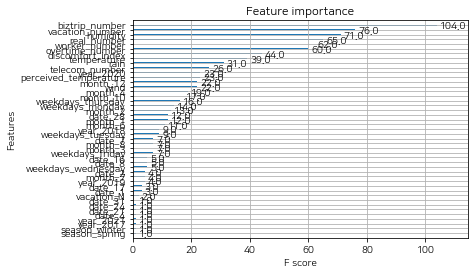

In [24]:
xgb.plot_importance(model)

In [25]:
pred = model.predict(lunch_X_test)
pred

array([ 885.8877 ,  794.1983 , 1223.9185 , 1136.2916 ,  737.0808 ,
       1007.04364, 1086.426  ,  519.8119 ,  903.4033 ,  865.42993,
        881.2333 , 1162.0223 , 1131.1565 ,  921.4428 ,  908.4274 ,
       1032.4493 ,  953.41125,  551.23334,  623.0806 , 1129.5492 ,
        879.37775,  555.7052 ,  880.17303,  858.84454,  957.83154,
        913.06805,  693.0731 ,  886.8988 ,  530.79   ,  672.9007 ,
        896.0049 ,  884.1988 ,  911.04297,  525.3153 ,  963.2154 ,
       1169.4473 ,  946.77313,  924.90576,  791.88635,  837.08154,
        824.07733,  633.9319 ,  702.2428 ,  704.4929 , 1176.8567 ,
        970.8271 , 1052.9459 ,  844.4112 ,  850.15796, 1208.8363 ,
       1219.9374 ,  887.00995,  867.4183 ,  739.895  ,  852.5577 ,
        714.2273 ,  703.8203 ,  705.74036, 1018.21295,  946.5297 ,
        795.39746, 1135.8949 ,  644.9801 ,  848.9449 , 1164.4419 ,
        758.22327, 1007.86035,  758.94727, 1218.241  ,  654.19403,
       1228.1754 ,  613.9799 , 1015.1499 , 1133.466  , 1133.60

In [26]:
score = model.score(lunch_X_train, lunch_y_train)
print("훈련결과 : {}".format(score))
print("점검결과 : {}".format(model.score(lunch_X_test, lunch_y_test)))

훈련결과 : 0.9023025200953646
점검결과 : 0.860508319733749


### 저녁

In [27]:
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1]
}
model = XGBRegressor()

gs = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=multiprocessing.cpu_count())

gs.fit(dinner_X_train, dinner_y_train)

print(gs.best_params_)
print(gs.best_score_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 300}
-8998.85170660378


In [44]:
model = XGBRegressor(n_estimators=300, colsample_bylevel=0.7, learning_rate=0.1, colsample_bytree=1, max_depth=2)

model.fit(dinner_X_train, dinner_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

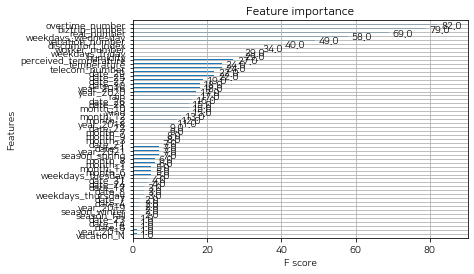

In [45]:
xgb.plot_importance(model)

In [46]:
pred = model.predict(dinner_X_test)
pred

array([475.35318, 520.44415, 387.70993, 407.34546, 314.63092, 410.4143 ,
       336.6692 , 386.52994, 540.35443, 407.34503, 425.75885, 388.33856,
       533.3915 , 452.56064, 526.96826, 530.51166, 306.64746, 469.34235,
       236.20943, 475.9912 , 381.9945 , 515.3661 , 492.94556, 384.88055,
       535.7939 , 542.8771 , 484.66876, 295.73184, 355.84753, 445.4067 ,
       483.8989 , 350.5261 , 481.86374, 426.47723, 508.36597, 511.41165,
       562.41235, 414.7803 , 427.3452 , 403.874  , 396.0232 , 433.6723 ,
       194.27306, 502.7773 , 531.14996, 639.4176 , 417.6316 , 447.4865 ,
       515.55597, 494.17722, 568.1013 , 526.67944, 565.29047, 550.5711 ,
       629.27   , 439.1853 , 298.42993, 372.35364, 351.21072, 534.02057,
       319.8255 , 492.4499 , 602.5479 , 338.51285, 525.39484, 535.12714,
       577.8551 , 461.05478, 480.7785 , 568.9825 , 360.4095 , 440.3149 ,
       587.7242 , 477.91058, 525.8583 , 552.0952 , 539.29944, 410.51453,
       343.01624, 486.73233, 510.43655, 530.45667, 

In [47]:
score = model.score(dinner_X_train, dinner_y_train)
print("훈련결과 : {}".format(score))
print("점검결과 : {}".format(model.score(dinner_X_test, dinner_y_test)))

훈련결과 : 0.7960968384558765
점검결과 : 0.5983145743541849


## 5. 릿지, 라쏘, 엘라스틱넷

### 1. 릿지 - 점심

In [48]:
param = {'alpha':[0.1, 1, 10, 100]}

model = Ridge()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(lunch_X_train,lunch_y_train)
print(gs.best_estimator_)

Ridge(alpha=10)


In [49]:
model = Ridge(alpha=10)

model.fit(lunch_X_train, lunch_y_train)

print("훈련 결과 : {}".format(model.score(lunch_X_train, lunch_y_train)))
print("점검 결과 : {}".format(model.score(lunch_X_test, lunch_y_test)))

훈련 결과 : 0.8051371079674186
점검 결과 : 0.8216060418923412


### 2. 릿지 - 저녁

In [50]:
param = {'alpha':[0.1, 1, 10, 100]}

model = Ridge()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(dinner_X_train,dinner_y_train)
print(gs.best_estimator_)

Ridge(alpha=10)


In [51]:
model = Ridge(alpha=10)

model.fit(dinner_X_train, dinner_y_train)

print("훈련 결과 : {}".format(model.score(dinner_X_train, dinner_y_train)))
print("점검 결과 : {}".format(model.score(dinner_X_test, dinner_y_test)))

훈련 결과 : 0.5846964863308441
점검 결과 : 0.5114079584877648


### 1. 라쏘 - 점심

In [52]:
param = {'alpha':[0.1, 1, 10, 100]}

model = Lasso()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(lunch_X_train,lunch_y_train)
print(gs.best_estimator_)

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+06, tolerance: 2.958e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.338e+06, tolerance: 2.916e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Lasso(alpha=1)


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.864e+04, tolerance: 3.763e+03
  model = cd_fast.enet_coordinate_descent(


In [53]:
model = Lasso(alpha=1)

model.fit(lunch_X_train, lunch_y_train)

print("훈련 결과 : {}".format(model.score(lunch_X_train, lunch_y_train)))
print("점검 결과 : {}".format(model.score(lunch_X_test, lunch_y_test)))

훈련 결과 : 0.79289893058166
점검 결과 : 0.825226121116565


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.864e+04, tolerance: 3.763e+03
  model = cd_fast.enet_coordinate_descent(


### 2. 릿지 - 저녁

In [278]:
param = {'alpha':[0.01, 0.1, 1, 10, 100]}

model = Lasso()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(dinner_X_train,dinner_y_train)
print(gs.best_estimator_)

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e+06, tolerance: 1.282e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.327e+05, tolerance: 1.433e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Lasso(alpha=0.1)


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+06, tolerance: 1.716e+03
  model = cd_fast.enet_coordinate_descent(


In [279]:
model = Lasso(alpha=0.1)

model.fit(dinner_X_train, dinner_y_train)

print("훈련 결과 : {}".format(model.score(dinner_X_train, dinner_y_train)))
print("점검 결과 : {}".format(model.score(dinner_X_test, dinner_y_test)))

훈련 결과 : 0.5915282738733196
점검 결과 : 0.49785499714720094


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+06, tolerance: 1.716e+03
  model = cd_fast.enet_coordinate_descent(


### 1. 엘라스틱넷 - 점심

In [280]:
param = {'alpha':[0.01, 0.1, 1, 10, 100]}

model = ElasticNet()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(lunch_X_train,lunch_y_train)
print(gs.best_estimator_)

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+06, tolerance: 2.958e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+06, tolerance: 2.916e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

ElasticNet(alpha=0.01)


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.739e+06, tolerance: 3.763e+03
  model = cd_fast.enet_coordinate_descent(


In [281]:
model = ElasticNet(alpha=0.01)

model.fit(lunch_X_train, lunch_y_train)

print("훈련 결과 : {}".format(model.score(lunch_X_train, lunch_y_train)))
print("점검 결과 : {}".format(model.score(lunch_X_test, lunch_y_test)))

훈련 결과 : 0.8068362251560386
점검 결과 : 0.8215253825745953


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.739e+06, tolerance: 3.763e+03
  model = cd_fast.enet_coordinate_descent(


### 2. 릿지 - 저녁

In [282]:
param = {'alpha':[0.005, 0.01, 0.1, 1, 10, 100]}

model = ElasticNet()
gs= GridSearchCV(estimator=model, param_grid=param, scoring='neg_mean_squared_error',cv=5)

gs.fit(dinner_X_train,dinner_y_train)
print(gs.best_estimator_)

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.582e+06, tolerance: 1.282e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e+06, tolerance: 1.433e+03
  model = cd_fast.enet_coordinate_descent(
/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

ElasticNet(alpha=0.01)


/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+06, tolerance: 1.716e+03
  model = cd_fast.enet_coordinate_descent(


In [283]:
model = Ridge(alpha=0.01)

model.fit(dinner_X_train, dinner_y_train)

print("훈련 결과 : {}".format(model.score(dinner_X_train, dinner_y_train)))
print("점검 결과 : {}".format(model.score(dinner_X_test, dinner_y_test)))

훈련 결과 : 0.5925658313245357
점검 결과 : 0.48988364101805504


## 6. KFold, Cross_val_score로 XGBoost Modeling

### 1. data

In [54]:
def split_lunch(data):
    data_train = data.drop(["lunch_number", "datetime"], axis = "columns")
    data_target = data.loc[:, 'lunch_number']
    times = ['year', 'month', 'date']
    for col in times:
        data_train[col] = data_train[col].astype('category')
    data_train = pd.get_dummies(data_train)

    return data_train, data_target

def split_dinner(data):
    data_train = data.drop(["dinner_number", "datetime"], axis = "columns")
    data_target = data.loc[:, 'dinner_number']
    times = ['year', 'month', 'date']
    for col in times:
        data_train[col] = data_train[col].astype('category')
    data_train = pd.get_dummies(data_train)

    return data_train, data_target

In [55]:
lunch = pd.read_csv("data/lunch_df_encoding.csv")
dinner = pd.read_csv("data/dinner_df_encoding.csv")

lunch_train, lunch_target = split_lunch(lunch)
dinner_train, dinner_target = split_dinner(dinner)

### 2. KFold & corss_val_score

In [57]:
kfold = KFold(n_splits=10, shuffle=True)

xgbr_lunch = XGBRegressor(n_estimators=300, colsample_bylevel=1, learning_rate=0.1, colsample_bytree=1, max_depth=2)
scores = cross_val_score(xgbr_lunch, lunch_train, lunch_target, cv=kfold, scoring="neg_mean_squared_error")
print(scores)
round(np.mean(scores)*100, 2)

[-7451.70953704 -8653.17292525 -9201.43070975 -6424.63335683
 -7204.93478234 -7378.33044376 -8299.87735814 -6881.57728521
 -8229.78757914 -8126.36244131]


-778518.16

In [58]:
kfold = KFold(n_splits=10, shuffle=True)

xgbr_dinner = XGBRegressor(n_estimators=300, colsample_bylevel=0.7, learning_rate=0.1, colsample_bytree=0.7, max_depth=4)
scores = cross_val_score(xgbr_dinner, dinner_train, dinner_target, cv=kfold, scoring="neg_mean_squared_error")
print(scores)
round(np.mean(scores)*100, 2)

[ -8068.26106854  -6060.29626615  -6240.03481917  -9736.91774656
  -8266.40857475  -6998.30098837  -6457.50156301  -8097.53875402
 -10713.85159381  -7605.32372466]


-782444.35

### 3. Test-data

In [59]:
def split_forecast(data):
    data = data.drop("datetime", axis = "columns")
    
    times = ['year', 'month', 'date']
    for col in times:
        data[col] = data[col].astype('category')
    
    data = pd.get_dummies(data)

    return data

def equal_columns(train, forecast):
    onehot_list = train.columns
    for c in onehot_list:
        if c not in forecast.columns:
            forecast[c] = 0

    data = forecast.loc[:, train.columns]

    return data

In [60]:
#### lunch
df = pd.read_csv("data/lunch_test_encoding.csv")

df = split_forecast(df)
lunch_forecast = equal_columns(lunch_train, df)

In [61]:
#### dinner

df = pd.read_csv("data/dinner_test_encoding.csv")

df = split_forecast(df)
dinner_forecast = equal_columns(dinner_train, df)

## 4. Predict

In [62]:
#### lunch

xgbr_lunch.fit(lunch_train, lunch_target)
lunch_forecast = xgbr_lunch.predict(lunch_forecast)
lunch_forecast = pd.DataFrame(lunch_forecast)
lunch_forecast

,0
0,1029.781616
1,937.481628
2,749.427856
3,1285.755737
4,1083.098145
5,967.697144
6,988.964111
7,711.650024
8,1314.591553
9,1079.361450


In [63]:
#### dinner
xgbr_dinner.fit(dinner_train, dinner_target)
dinner_forecast = xgbr_dinner.predict(dinner_forecast)
dinner_forecast = pd.DataFrame(dinner_forecast)
dinner_forecast

,0
0,250.138245
1,425.636963
2,175.367050
3,573.584961
4,485.291351
5,388.156189
6,488.630310
7,387.139313
8,666.938232
9,545.182922


In [64]:
lunch_forecast.columns = ['lunch']
dinner_forecast.columns = ['dinner']

In [65]:
lunch_forecast.head()

,lunch
0,1029.781616
1,937.481628
2,749.427856
3,1285.755737
4,1083.098145


In [66]:
dinner_forecast.head()

,dinner
0,250.138245
1,425.636963
2,175.367050
3,573.584961
4,485.291351


In [69]:
lunch_forecast.to_csv("data/forecast/lunch.csv", encoding='utf-8', index=False)
dinner_forecast.to_csv("data/forecast/dinner.csv", encoding='utf-8', index=False)